In [1]:
import numpy
from scipy import linalg, special, integrate
from scipy.integrate import solve_ivp
from matplotlib import pyplot
import matplotlib

#matplotlib.rc("font", **{"family":  "serif", "weight": "normal", "size": 20})

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": "28",
    "text.latex.preamble": "\\usepackage[utf8]{inputenc}\\usepackage[T1]{fontenc}\\usepackage{lmodern}"
})

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [2]:
d_ops, d_dags = bmme.generate_fermionic_ops(2)

omega = .003
g = .0075
t = .01
Gamma = .005
T = .01 / bmme.k_B # 116
voltage = .0

def func_H_s(x):
    H_s = .5 * omega * x[0]**2 * numpy.identity(d_ops[0].shape[0])
    H_s += g * x[0] * numpy.sqrt(2) * d_dags[0] @ d_ops[0]
    H_s += t * (d_dags[0] @ d_ops[1] + d_dags[1] @ d_ops[0])
    return H_s

def func_ddx_H_s(k, x):
    ddx = omega * x[0] * numpy.identity(d_ops[0].shape[0])
    ddx += g * numpy.sqrt(2) * d_dags[0] @ d_ops[0]
    return ddx

x = numpy.linspace(-10, 10, 100)

mean_force = numpy.zeros(len(x), dtype=numpy.float64)
friction = numpy.zeros(len(x), dtype=numpy.float64)
correlation = numpy.zeros(len(x), dtype=numpy.float64)
rho = numpy.zeros((len(x), 4, 4), dtype=numpy.complex128)

def diagonalize(matrix):
    return numpy.linalg.eig(matrix)

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, [val], d_ops, None, numpy.array([[0,0],[0,Gamma]]), -.5 * voltage, .5 * voltage, T, T, diagonalize=diagonalize, include_digamma=False)

def my_func2(i, val):
    solver = bmme.general_solver(func_H_s([val]), d_ops, None, numpy.array([[0,0],[0,Gamma]]), -.5 * voltage, .5 * voltage, T, T, diagonalize=diagonalize, include_digamma=False)
    r, L = solver.find_steady_state()
    return solver.V @ r @ solver.V_dag

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))
results2 = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func2)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-10:
        print("ALARM!!! Mean force")
    else:
        mean_force[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-10:
        print("ALARM!!! Friction")
    else:
        friction[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-10:
        print("ALARM!!! Correlation")
    else:
        correlation[i] = results[i][2].real
        
for i in range(len(results2)):
    rho[i] = results2[i]
        
#pmf = numpy.zeros(len(x), dtype=numpy.float64)
#for i in range(len(x)):
#    pmf[i] = -numpy.sum(mean_force[:i+1]) * (max(x) - min(x)) / (len(x) - 1)

c:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


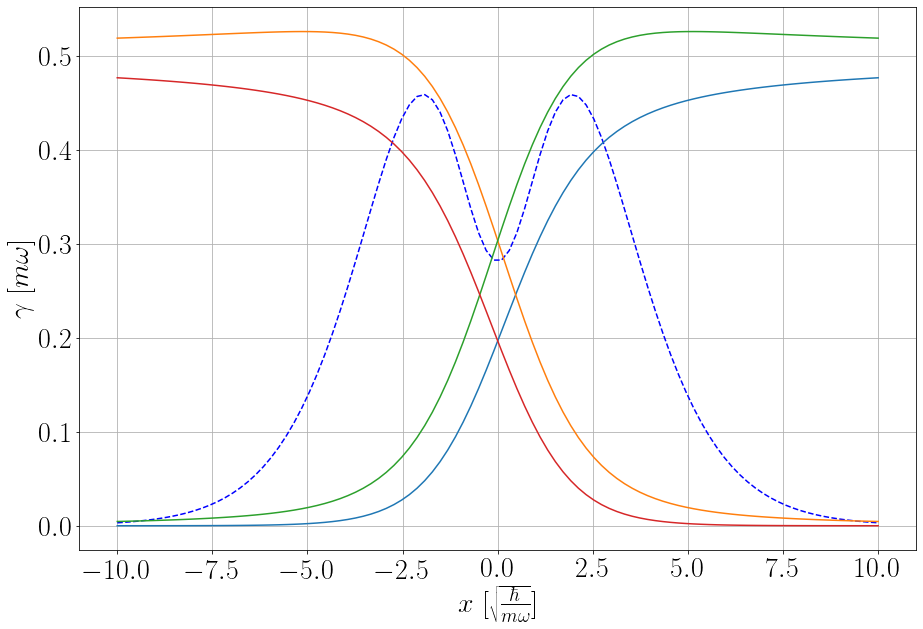

In [3]:
pyplot.figure(figsize=(15, 10))

#pyplot.plot(x, pmf-min(pmf))
pyplot.plot(x, bmme._hbar * friction, c="blue", ls="--")
#pyplot.plot(x, bmme._hbar * correlation / (bmme.k_B * T), "--", c="red")
pyplot.plot(x, rho[:,0,0])
pyplot.plot(x, rho[:,1,1])
pyplot.plot(x, rho[:,2,2])
pyplot.plot(x, rho[:,3,3])
#pyplot.plot(x, rho[:,0,0]+rho[:,1,1]+rho[:,2,2]+rho[:,3,3])
pyplot.xlabel("$x$ [$\\sqrt{\\frac{\\hbar}{m\\omega}}$]")
pyplot.ylabel("$\\gamma$ [$m\\omega$]")
#pyplot.ylim(0, .45)
pyplot.grid()
pyplot.show()

In [16]:
d_ops, d_dags = bmme.generate_fermionic_ops(2)

omega = .003
g = .0075
t = .01
Gamma = .005
Delta = .01
T = .01 / bmme.k_B # 116
voltage = .0

def func_H_s(x):
    H_s = .5 * omega * x[0]**2 * numpy.identity(d_ops[0].shape[0])
    H_s += (g * x[0] * numpy.sqrt(0.5) - numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[0] @ d_ops[0]
    H_s += (g * x[0] * numpy.sqrt(0.5) + numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[1] @ d_ops[1]
    H_s += t * (d_dags[0] @ d_ops[1] + d_dags[1] @ d_ops[0])
    return H_s

def func_ddx_H_s(k, x):
    ddx = omega * x[0] * numpy.identity(d_ops[0].shape[0])
    ddx += (g * numpy.sqrt(0.5) - (g**2 / 2) * x[0] / numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[0] @ d_ops[0]
    ddx += (g * numpy.sqrt(0.5) + (g**2 / 2) * x[0] / numpy.sqrt((x[0] * g)**2 / 2 + Delta**2)) * d_dags[1] @ d_ops[1]
    return ddx

x = numpy.linspace(-10, 10, 100)

mean_force = numpy.zeros(len(x), dtype=numpy.float64)
friction = numpy.zeros(len(x), dtype=numpy.float64)
correlation = numpy.zeros(len(x), dtype=numpy.float64)
rho = numpy.zeros((len(x), 4, 4), dtype=numpy.complex128)

def diagonalize(matrix):
    return numpy.linalg.eig(matrix)

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, [val], d_ops, None, numpy.array([[Gamma,-Gamma],[-Gamma,Gamma]]), -.5 * voltage, .5 * voltage, T, T, diagonalize=diagonalize, include_digamma=False)

def my_func2(i, val):
    solver = bmme.general_solver(func_H_s([val]), d_ops, None, numpy.array([[Gamma,-Gamma],[-Gamma,Gamma]]), -.5 * voltage, .5 * voltage, T, T, diagonalize=diagonalize, include_digamma=False)
    r, L = solver.find_steady_state()
    return solver.V @ r @ solver.V_dag

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))
results2 = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func2)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-10:
        print("ALARM!!! Mean force")
    else:
        mean_force[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-10:
        print("ALARM!!! Friction")
    else:
        friction[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-10:
        print("ALARM!!! Correlation")
    else:
        correlation[i] = results[i][2].real
        
for i in range(len(results2)):
    rho[i] = results2[i]
        
#pmf = numpy.zeros(len(x), dtype=numpy.float64)
#for i in range(len(x)):
#    pmf[i] = -numpy.sum(mean_force[:i+1]) * (max(x) - min(x)) / (len(x) - 1)

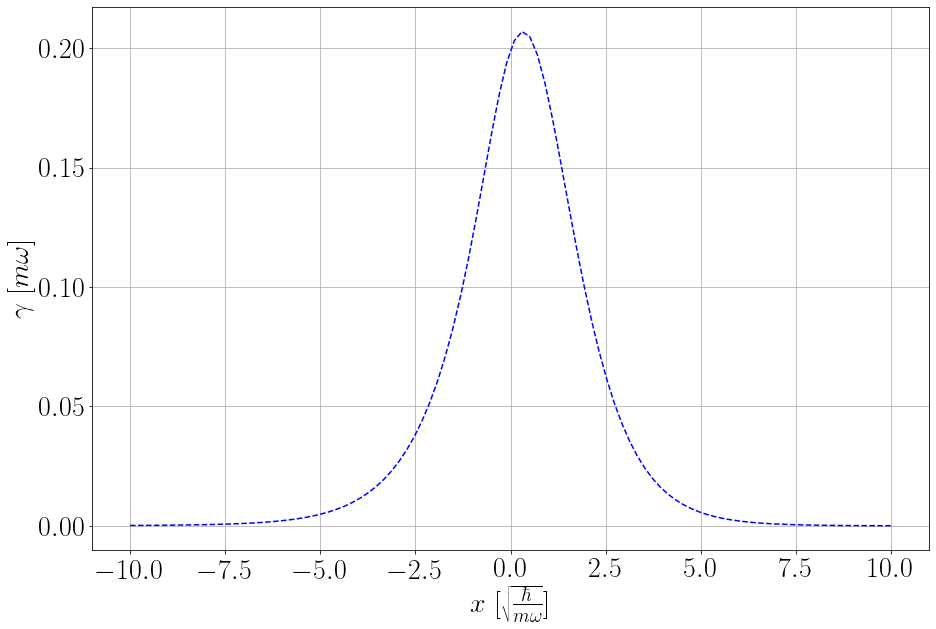

In [17]:
pyplot.figure(figsize=(15, 10))

#pyplot.plot(x, pmf-min(pmf))
pyplot.plot(x, bmme._hbar * friction, c="blue", ls="--")
#pyplot.plot(x, bmme._hbar * correlation / (bmme.k_B * T), "--", c="red")
#pyplot.plot(x, rho[:,0,0])
#pyplot.plot(x, rho[:,1,1])
#pyplot.plot(x, rho[:,2,2])
#pyplot.plot(x, rho[:,3,3])
#pyplot.plot(x, rho[:,0,0]+rho[:,1,1]+rho[:,2,2]+rho[:,3,3])
pyplot.xlabel("$x$ [$\\sqrt{\\frac{\\hbar}{m\\omega}}$]")
pyplot.ylabel("$\\gamma$ [$m\\omega$]")
#pyplot.ylim(0, .45)
pyplot.grid()
pyplot.show()